<a href="https://colab.research.google.com/github/ShamnazVH/Spam-Email-Detector/blob/main/Spam_Email_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spam Detector: Machine Learning Model for Email Classification**

This project is a complete end-to-end machine learning pipeline built to detect spam vs. ham (legitimate) emails with high accuracy. Using a dataset of email messages, the model applies advanced text preprocessing, feature engineering, and TF–IDF vectorization, combined with traditional ML algorithms such as Naive Bayes, Logistic Regression, SVM, and Random Forest. After evaluating multiple models, the best-performing one is selected, tuned, and deployed.

The notebook trains the model in Google Colab, saves it using pickle, and provides the necessary files (spam_model.pkl, vectorizer.pkl, model_info.pkl) for easy deployment through Flask or Streamlit on local machines.

Key steps include:

*   Data cleaning & preprocessing with NLTK

*   Feature engineering (length, special characters, URLs, etc.)

*   Model training, evaluation & hyperparameter tuning

*   TF–IDF text vectorization

*   Confusion matrix visualization

*   Model export and sample predictions

✅ Outcome: A ready-to-deploy, lightweight spam detection system capable of real-time classification of incoming messages with high accuracy.

In [ ]:
# ============================================================================
#  SPAM DETECTOR - TRAIN IN GOOGLE COLAB
# ============================================================================

# Install required libraries (Colab already has most)
!pip install -q scikit-learn pandas numpy matplotlib seaborn nltk

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import hstack

print("="*70)
print("  TRAINING SPAM DETECTOR IN GOOGLE COLAB")
print("="*70)


  TRAINING SPAM DETECTOR IN GOOGLE COLAB


In [ ]:

# Download NLTK data
print("\n[1/12] Downloading NLTK data...")
nltk.download('stopwords', quiet=True)
print("✓ Complete!")


[1/12] Downloading NLTK data...
✓ Complete!


In [ ]:
# ================================
# 1. LOAD AND EXPLORE DATA
# ================================
df = pd.read_csv('spam.csv', encoding='latin-1')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (5572, 2)

First few rows:
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# Keep only relevant columns (assuming first two columns are Category and Message)
df = df.iloc[:, :2]
df.columns = ['Category', 'Message']

print("\n" + "="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"\nTotal emails: {len(df)}")
print(f"\nClass distribution:\n{df['Category'].value_counts()}")
print(f"\nMissing values:\n{df.isnull().sum()}")



DATA OVERVIEW

Total emails: 5572

Class distribution:
Category
ham     4825
spam     747
Name: count, dtype: int64

Missing values:
Category    0
Message     0
dtype: int64


In [ ]:

# ================================
# 2. ADVANCED TEXT PREPROCESSING
# ================================
def preprocess_text(text):
    """Advanced text preprocessing"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove phone numbers
    text = re.sub(r'\b\d{10}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stopwords and apply stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

# Apply preprocessing
print("\n" + "="*60)
print("PREPROCESSING TEXT")
print("="*60)
df['Processed_Message'] = df['Message'].apply(preprocess_text)
print("Preprocessing complete!")


PREPROCESSING TEXT
Preprocessing complete!


In [ ]:

# ================================
# 3. FEATURE ENGINEERING
# ================================
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Create additional features
df['Length'] = df['Message'].apply(len)
df['Word_Count'] = df['Message'].apply(lambda x: len(x.split()))
df['Capital_Ratio'] = df['Message'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1))
df['Special_Char_Count'] = df['Message'].apply(lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace()))
df['Has_URL'] = df['Message'].apply(lambda x: 1 if re.search(r'http\S+|www\S+', x) else 0)
df['Has_Email'] = df['Message'].apply(lambda x: 1 if re.search(r'\S+@\S+', x) else 0)
df['Has_Phone'] = df['Message'].apply(lambda x: 1 if re.search(r'\d{10}|\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', x) else 0)

# Create binary target
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

print("Features created:")
print(df[['Length', 'Word_Count', 'Capital_Ratio', 'Special_Char_Count']].describe())



FEATURE ENGINEERING
Features created:
            Length   Word_Count  Capital_Ratio  Special_Char_Count
count  5572.000000  5572.000000    5572.000000         5572.000000
mean     80.494616    15.584171       0.065047            4.278177
std      59.998745    11.406598       0.107139            4.665375
min       2.000000     1.000000       0.000000            0.000000
25%      36.000000     7.000000       0.025447            2.000000
50%      61.000000    12.000000       0.037037            3.000000
75%     122.000000    23.000000       0.060606            6.000000
max     910.000000   171.000000       0.878049          133.000000


In [ ]:
# ================================
# 4. PREPARE DATA FOR MODELING
# ================================
# Split data
X_text = df['Processed_Message']
X_features = df[['Length', 'Word_Count', 'Capital_Ratio', 'Special_Char_Count',
                  'Has_URL', 'Has_Email', 'Has_Phone']]
y = df['Spam']

X_train_text, X_test_text, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")



TRAIN-TEST SPLIT
Training set size: 4457
Test set size: 1115


In [ ]:
# ================================
# 5. VECTORIZATION WITH TF-IDF
# ================================
print("\n" + "="*60)
print("TEXT VECTORIZATION")
print("="*60)

# Use TF-IDF with n-grams
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Train matrix shape: {X_train_vec.shape}")

# Combine text features with additional features
from scipy.sparse import hstack
X_train_combined = hstack([X_train_vec, X_train_feat.values])
X_test_combined = hstack([X_test_vec, X_test_feat.values])


TEXT VECTORIZATION
Vocabulary size: 3000
Train matrix shape: (4457, 3000)


In [ ]:

# ================================
# 6. MODEL TRAINING & COMPARISON
# ================================
print("\n" + "="*60)
print("MODEL TRAINING & COMPARISON")
print("="*60)

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_combined, y_train)

    # Predict
    y_pred = model.predict(X_test_combined)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_combined, y_train, cv=5)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"{name} - Accuracy: {accuracy:.4f}")
    print(f"{name} - CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))



MODEL TRAINING & COMPARISON

Training Naive Bayes...
Naive Bayes - Accuracy: 0.9731
Naive Bayes - CV Score: 0.9661 (+/- 0.0037)

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.99      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115


Training Logistic Regression...
Logistic Regression - Accuracy: 0.9722
Logistic Regression - CV Score: 0.9666 (+/- 0.0026)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115


Trai

In [ ]:

# ================================
# 7. SELECT BEST MODEL
# ================================
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print("\n" + "="*60)
print(f"BEST MODEL: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print("="*60)


BEST MODEL: SVM
Accuracy: 0.9892


In [ ]:
#===============================
# 8. HYPERPARAMETER TUNING (Optional - for best model)
# ================================
if best_model_name == 'Logistic Regression':
    print("\nPerforming hyperparameter tuning...")
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_combined, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")


Confusion matrix saved as 'confusion_matrix.png'


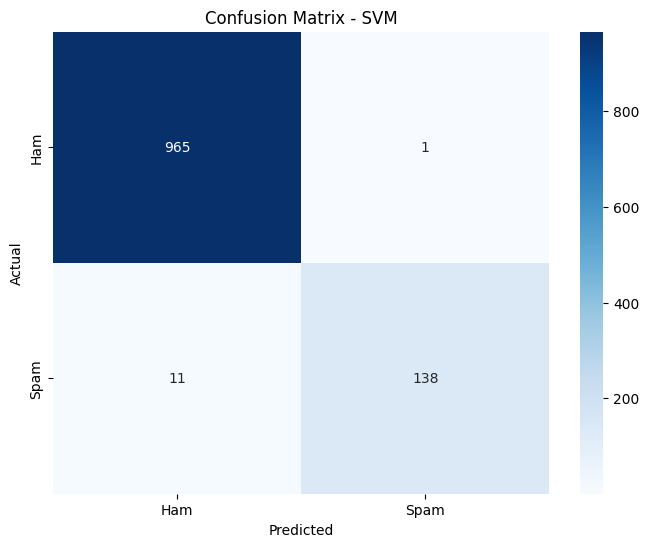

In [ ]:

# ================================
# 9. CONFUSION MATRIX VISUALIZATION
# ================================
y_pred_best = best_model.predict(X_test_combined)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved as 'confusion_matrix.png'")


In [ ]:
# ================================
# 10. SAVE MODEL AND COMPONENTS
# ================================
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save all components
with open('spam_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model_info.pkl', 'wb') as f:
    pickle.dump({
        'model_name': best_model_name,
        'accuracy': results[best_model_name]['accuracy'],
        'feature_names': ['Length', 'Word_Count', 'Capital_Ratio', 'Special_Char_Count',
                         'Has_URL', 'Has_Email', 'Has_Phone']
    }, f)

print("✓ Model saved as 'spam_model.pkl'")
print("✓ Vectorizer saved as 'vectorizer.pkl'")
print("✓ Model info saved as 'model_info.pkl'")


SAVING MODEL
✓ Model saved as 'spam_model.pkl'
✓ Vectorizer saved as 'vectorizer.pkl'
✓ Model info saved as 'model_info.pkl'


In [ ]:

# ================================
# 11. TEST WITH SAMPLE EMAILS
# ================================
print("\n" + "="*60)
print("TESTING WITH SAMPLE EMAILS")
print("="*60)

def predict_email(email_text):
    """Predict if an email is spam or ham"""
    # Preprocess
    processed = preprocess_text(email_text)

    # Extract features
    length = len(email_text)
    word_count = len(email_text.split())
    capital_ratio = sum(1 for c in email_text if c.isupper()) / (len(email_text) + 1)
    special_char_count = sum(1 for c in email_text if not c.isalnum() and not c.isspace())
    has_url = 1 if re.search(r'http\S+|www\S+', email_text) else 0
    has_email = 1 if re.search(r'\S+@\S+', email_text) else 0
    has_phone = 1 if re.search(r'\d{10}|\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', email_text) else 0

    # Vectorize
    text_vec = vectorizer.transform([processed])

    # Combine features
    features = np.array([[length, word_count, capital_ratio, special_char_count,
                         has_url, has_email, has_phone]])
    combined = hstack([text_vec, features])

    # Predict
    prediction = best_model.predict(combined)[0]
    probability = best_model.predict_proba(combined)[0] if hasattr(best_model, 'predict_proba') else None

    return 'Spam' if prediction == 1 else 'Ham', probability

# Test samples
test_emails = [
    "Hey mohan, can we get together to watch football game tomorrow?",
    "Upto 20% discount on parking, exclusive offer just for you. Don't miss this reward!",
    "URGENT! You've won $1000000! Click here now to claim your prize!!!",
    "Hi, just checking if we're still on for dinner tonight?"
]

for i, email in enumerate(test_emails, 1):
    result, prob = predict_email(email)
    print(f"\nEmail {i}: {email[:60]}...")
    print(f"Prediction: {result}")
    if prob is not None:
        print(f"Confidence: Spam={prob[1]:.2%}, Ham={prob[0]:.2%}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)


TESTING WITH SAMPLE EMAILS

Email 1: Hey mohan, can we get together to watch football game tomorr...
Prediction: Ham

Email 2: Upto 20% discount on parking, exclusive offer just for you. ...
Prediction: Ham

Email 3: URGENT! You've won $1000000! Click here now to claim your pr...
Prediction: Spam

Email 4: Hi, just checking if we're still on for dinner tonight?...
Prediction: Ham

MODEL TRAINING COMPLETE!


In [ ]:
# Download files directly
from google.colab import files

print("Downloading files...")
files.download('spam_model.pkl')
files.download('vectorizer.pkl')
files.download('model_info.pkl')
files.download('confusion_matrix.png')
print("✓ All files downloaded!")

# Display files created
print("\n📁 Files created:")
print("  1. spam_model.pkl")
print("  2. vectorizer.pkl")
print("  3. model_info.pkl")
print("  4. confusion_matrix.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ All files downloaded!

📁 Files created:
  1. spam_model.pkl
  2. vectorizer.pkl
  3. model_info.pkl
  4. confusion_matrix.png
